<div style="position: absolute; top: 0; left: 0; font-family: 'Garamond'; font-size: 16px;">
    <a href="https://github.com/patriciaapenat" style="text-decoration: none; color: inherit;">Patricia Peña Torres</a>
</div>

<div align="center" style="font-family: 'Garamond'; font-size: 48px;">
    <strong>Proyecto final, BRFSS-clustering</strong>
</div>

<div align="center" style="font-family: 'Garamond'; font-size: 36px;">
    <strong>0.2. Análisis exploratorio</strong>
</div>

__________________

<div style="font-family: 'Garamond'; font-size: 14px;">

En este notebook se llava a cabo lo relativo al análisis exploratorio, por la naturaleza de los datos este EDA se ha centrado principalmente en variables demográficas
    
</div>

<div style="font-family: 'Garamond'; font-size: 16px;">
    <strong>Configuración del entorno de trabajo</strong>
</div>

In [1]:
import pandas as pd
import findspark
findspark.init()
import pyspark
import random
import os.path
import seaborn as sns
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import os
from pyspark.sql import DataFrame
import pickle
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import warnings

# Ignorar advertencias deprecated
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# configurar gráficos
sns.set(style="whitegrid", context="notebook", palette="mako")

<div style="font-family: 'Garamond'; font-size: 14px;">
    <strong>Configuración de Spark</strong>
</div>

In [3]:
# Si hay un SparkContext existente, debemos cerrarlo antes de crear uno nuevo
if 'sc' in locals() and sc:
    sc.stop()  # Detener el SparkContext anterior si existe

# Configuración de Spark
conf = (
    SparkConf()
    .setAppName("Proyecto_PatriciaA_Peña")  # Nombre de la aplicación en Spark
    .setMaster("local[1]")  # Modo local con un hilo para ejecución
    .set("spark.driver.host", "127.0.0.1")  # Dirección del host del driver
    .set("spark.executor.heartbeatInterval", "3600s")  # Intervalo de latido del executor
    .set("spark.network.timeout", "7200s")  # Tiempo de espera de la red
)

# Crear un nuevo SparkContext con la configuración especificada
sc = SparkContext(conf=conf)

# Configuración de SparkSession (interfaz de alto nivel para trabajar con datos estructurados en Spark)
spark = (
    SparkSession.builder
    .appName("Proyecto_PatriciaA_Peña")  # Nombre de la aplicación en Spark
    .config("spark.sql.repl.eagerEval.enabled", True)  # Habilitar la evaluación perezosa en Spark SQL REPL
    .config("spark.sql.repl.eagerEval.maxNumRows", 1000)  # Número máximo de filas a mostrar en la evaluación perezosa
    .getOrCreate()  # Obtener la sesión Spark existente o crear una nueva si no existe
)

<div style="font-family: 'Garamond'; font-size: 14px;">
    <strong>Lectura del archivo</strong>
</div>

In [4]:
df = spark.read.format("csv").option("header", "true").load(r"C:\Users\patri\OneDrive - UAB\Documentos\GitHub\BRFSS-clustering\datos\BRFSS_Cleaner_2022.csv")

<div style="font-family: 'Garamond'; font-size: 16px;">
    <strong>Representación por sexo</strong>
</div>

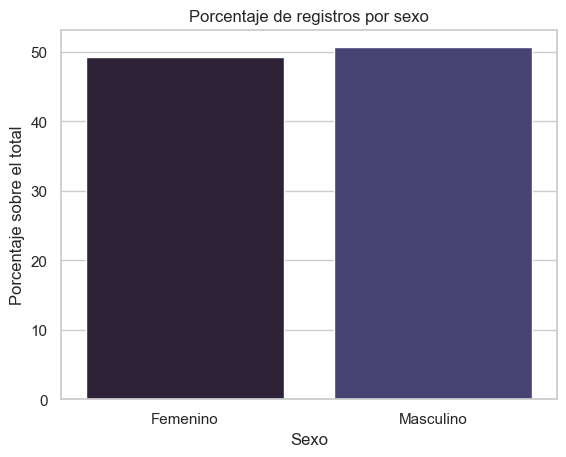

In [5]:
sns.barplot(x="_SEX", y="percentage", data=(df.groupBy("_SEX").count().toPandas().replace({"1.0": "Femenino", "2.0": "Masculino"}).assign(percentage=lambda x: (x["count"] / x["count"].sum()) * 100)))

# Ajusta las etiquetas de los ejes y el título del gráfico
plt.xlabel("Sexo")
plt.ylabel("Porcentaje sobre el total")
plt.title("Porcentaje de registros por sexo")

# Muestra el gráfico
plt.show()

<div style="font-family: 'Garamond'; font-size: 14px;">

Cuando trabajamos con Spark, enfrentamos dificultades adicionales para llevar a cabo visualizaciones. En este caso, seguimos estos pasos:

1. **Agrupación y Conteo**: Primeramente, se agrupan los datos por la columna "_SEX" y se cuentan los registros, generando un DataFrame de PySpark.

2. **Conversión a Pandas y Reemplazo de Etiquetas**: Seguidamente, convertimos este DataFrame a un DataFrame de Pandas y utilizamos el método `replace` para cambiar los valores de la columna "_SEX". Esto nos permite asignar etiquetas más descriptivas, como "Femenino" y "Masculino", en lugar de los valores numéricos "1.0" y "2.0", respectivamente.

3. **Visualización con Seaborn**: Después, Seaborn crea un gráfico de barras. En este gráfico, la columna "_SEX" se encuentra en el eje x, la columna "count" en el eje y, y los datos provienen del DataFrame de Pandas modificado. Este gráfico representa el conteo de registros por género.

</div>


Podemos ver que hay un balance relativamente parejo en este caso, ahora podríamos revisar por ejemplo la edad

<div style="font-family: 'Garamond'; font-size: 16px;">
    <strong>Representación por grupo étnico o racial</strong>
</div>

<div style="font-family: 'Garamond'; font-size: 14px;">
Algo común en las investigaciones llevadas a cabo en Estados Unidos son preguntas al respecto de la raza. género.de la raza.

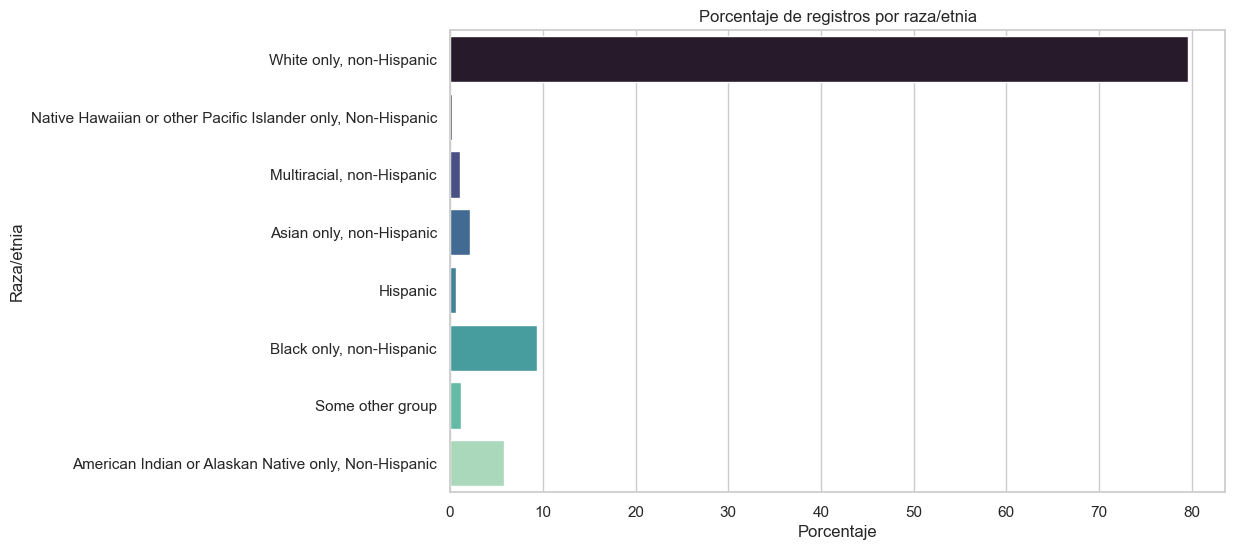

In [6]:
race_data = (df.filter(~df["RRCLASS3"].isin(["77.0", "99.0"]))
        .groupBy("RRCLASS3").count()
        .toPandas()
        .replace({
            "1.0": "White only, non-Hispanic", 
            "2.0": "Black only, non-Hispanic",
            "3.0": "American Indian or Alaskan Native only, Non-Hispanic",
            "4.0": "Asian only, non-Hispanic",
            "5.0": "Native Hawaiian or other Pacific Islander only, Non-Hispanic",
            "6.0": "Multiracial, non-Hispanic",
            "7.0": "Hispanic",
            "8.0": "Some other group" 
        })
        .assign(percentage=lambda x: (x["count"] / x["count"].sum()) * 100))

plt.figure(figsize=(10, 6))
sns.barplot(x="percentage", y="RRCLASS3", data=race_data, orient="h", palette="mako")

plt.xlabel("Porcentaje")
plt.ylabel("Raza/etnia")
plt.title("Porcentaje de registros por raza/etnia")

# Muestra el gráfico
plt.show()

<div style="font-family: 'Garamond'; font-size: 14px;">Podemos observar que más del 80% se identifica como 'White only, non-Hispanic'. A continuación, le siguen `Black only, non-Hispanic' y 'American Indian or Alaskan Native only, non-Hispanic'. Dado que estamos trabajando con una muestra tan desbalanceada, es importante tener en cuenta que probablemente no sea factible realizar análisis específicos según fenotipos..

<div style="font-family: 'Garamond'; font-size: 16px;">
    <strong>Representación por Estados</strong>
</div>

<div style="font-family: 'Garamond'; font-size: 14px;">
Al respecto de la representación de los estados podemos ver lo siguiente

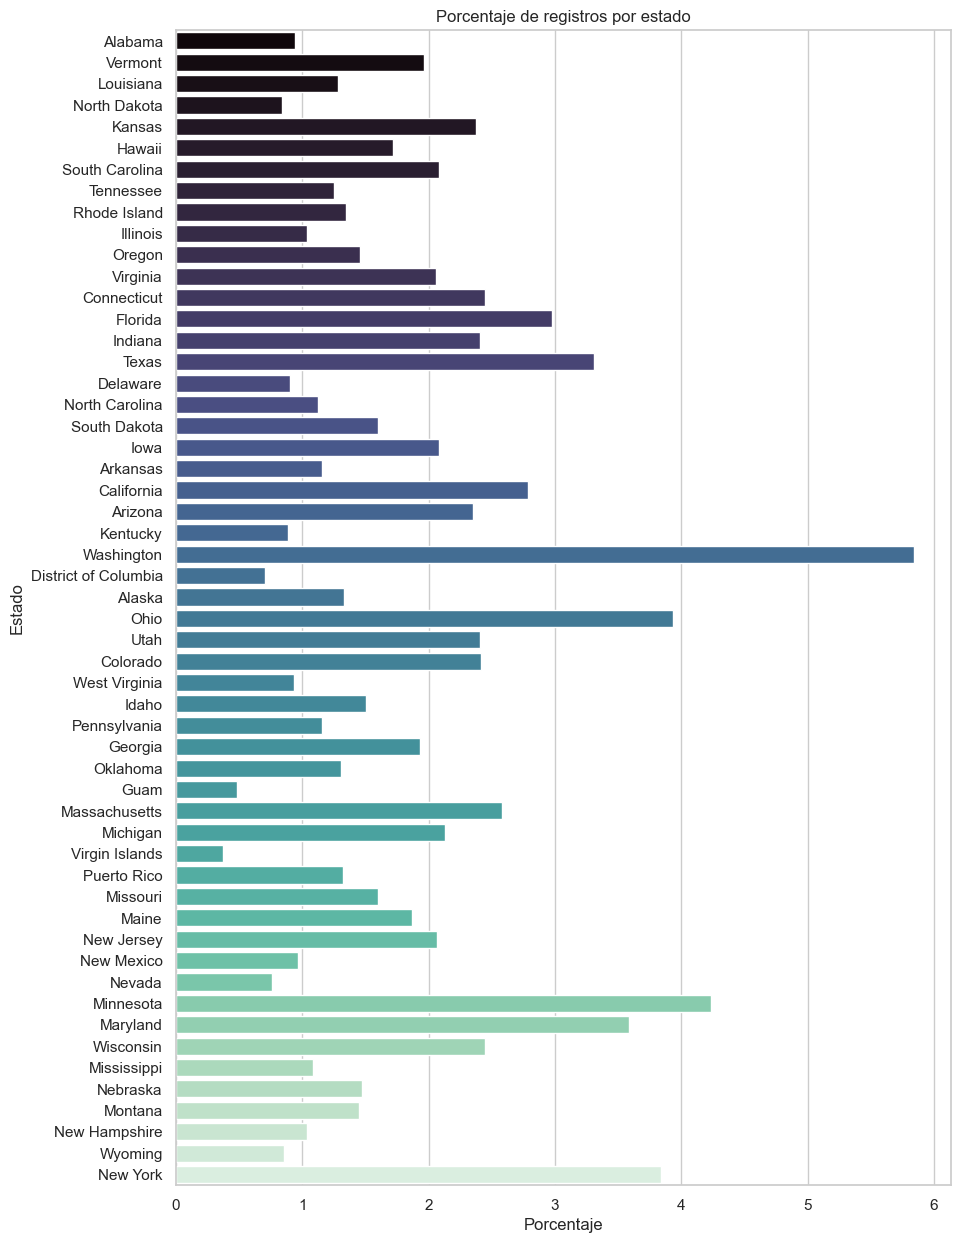

In [7]:
state_mapping = {
    "1.0": "Alabama", "2.0": "Alaska", "4.0": "Arizona", "5.0": "Arkansas", "6.0": "California",
    "8.0": "Colorado", "9.0": "Connecticut", "10.0": "Delaware", "11.0": "District of Columbia", "12.0": "Florida",
    "13.0": "Georgia", "15.0": "Hawaii", "16.0": "Idaho", "17.0": "Illinois", "18.0": "Indiana", "19.0": "Iowa",
    "20.0": "Kansas", "21.0": "Kentucky", "22.0": "Louisiana", "23.0": "Maine", "24.0": "Maryland", "25.0": "Massachusetts",
    "26.0": "Michigan", "27.0": "Minnesota", "28.0": "Mississippi", "29.0": "Missouri", "30.0": "Montana",
    "31.0": "Nebraska", "32.0": "Nevada", "33.0": "New Hampshire", "34.0": "New Jersey", "35.0": "New Mexico",
    "36.0": "New York", "37.0": "North Carolina", "38.0": "North Dakota", "39.0": "Ohio", "40.0": "Oklahoma",
    "41.0": "Oregon", "42.0": "Pennsylvania", "44.0": "Rhode Island", "45.0": "South Carolina", "46.0": "South Dakota",
    "47.0": "Tennessee", "48.0": "Texas", "49.0": "Utah", "50.0": "Vermont", "51.0": "Virginia", "53.0": "Washington",
    "54.0": "West Virginia", "55.0": "Wisconsin", "56.0": "Wyoming", "66.0": "Guam", "72.0": "Puerto Rico",
    "78.0": "Virgin Islands"
}

df_states_replaced = (df.groupBy("_STATE").count()
                     .toPandas()
                     .replace({"_STATE": state_mapping})
                     .astype({"_STATE": str})
                     .assign(percentage=lambda x: (x["count"] / x["count"].sum()) * 100)) # Calculamos el porcentaje

plt.figure(figsize=(10, 15))
sns.barplot(x="percentage", y="_STATE", data=df_states_replaced, palette="mako", errorbar=None)

plt.xlabel("Porcentaje")
plt.ylabel("Estado")
plt.title("Porcentaje de registros por estado")

plt.show()

<div style="font-family: 'Garamond'; font-size: 16px;">
    <strong>Representación por grupo etario</strong>
</div>

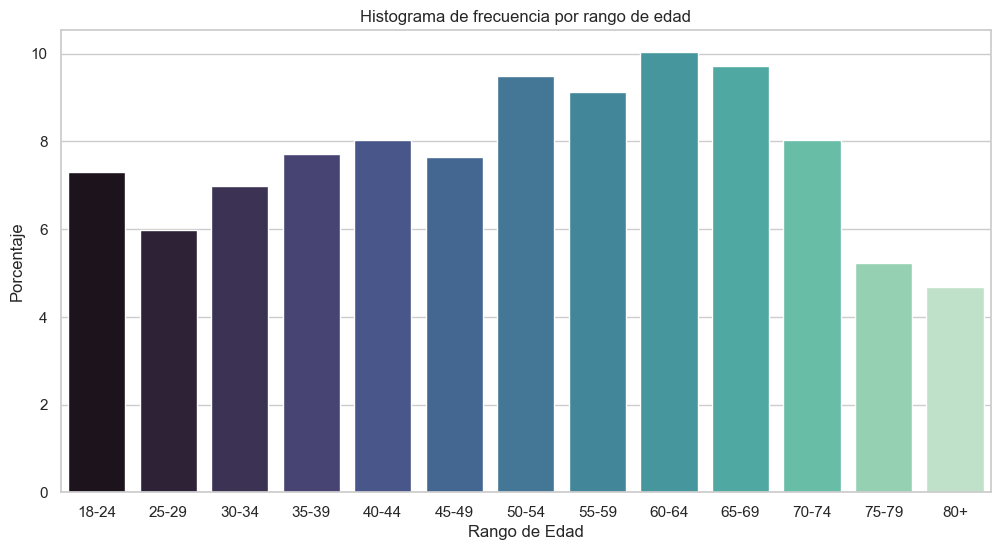

In [8]:
# Definir los límites de los rangos de edad
bin_edges = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 100]

# Etiquetas para los rangos de edad
age_labels = ["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "80+"]

# Crear una nueva columna con etiquetas de rangos de edad
df_with_age_range = df.withColumn("_AGE80_RANGE", F.when((F.col("_AGE80") >= bin_edges[0]) & (F.col("_AGE80") < bin_edges[1]), age_labels[0])
                                  .when((F.col("_AGE80") >= bin_edges[1]) & (F.col("_AGE80") < bin_edges[2]), age_labels[1])
                                  .when((F.col("_AGE80") >= bin_edges[2]) & (F.col("_AGE80") < bin_edges[3]), age_labels[2])
                                  .when((F.col("_AGE80") >= bin_edges[3]) & (F.col("_AGE80") < bin_edges[4]), age_labels[3])
                                  .when((F.col("_AGE80") >= bin_edges[4]) & (F.col("_AGE80") < bin_edges[5]), age_labels[4])
                                  .when((F.col("_AGE80") >= bin_edges[5]) & (F.col("_AGE80") < bin_edges[6]), age_labels[5])
                                  .when((F.col("_AGE80") >= bin_edges[6]) & (F.col("_AGE80") < bin_edges[7]), age_labels[6])
                                  .when((F.col("_AGE80") >= bin_edges[7]) & (F.col("_AGE80") < bin_edges[8]), age_labels[7])
                                  .when((F.col("_AGE80") >= bin_edges[8]) & (F.col("_AGE80") < bin_edges[9]), age_labels[8])
                                  .when((F.col("_AGE80") >= bin_edges[9]) & (F.col("_AGE80") < bin_edges[10]), age_labels[9])
                                  .when((F.col("_AGE80") >= bin_edges[10]) & (F.col("_AGE80") < bin_edges[11]), age_labels[10])
                                  .when((F.col("_AGE80") >= bin_edges[11]) & (F.col("_AGE80") < bin_edges[12]), age_labels[11])
                                  .otherwise(age_labels[12]))

# Calcular el histograma y ordenar las barras por rango de edad
age_data = (df_with_age_range.groupBy("_AGE80_RANGE").count()
            .toPandas()
            .astype({"_AGE80_RANGE": str})
            .sort_values(by="_AGE80_RANGE")
            .assign(percentage=lambda x: (x["count"] / x["count"].sum()) * 100))

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="_AGE80_RANGE", y="percentage", data=age_data, palette="mako")

# Ajustar etiquetas y título
plt.xlabel("Rango de Edad")
plt.ylabel("Porcentaje")
plt.title("Histograma de frecuencia por rango de edad")

# Mostrar el gráfico
plt.show()

<div style="font-family: 'Garamond'; font-size: 14px;">
    
Primero, se definen los límites de los Rangos de Edad en la lista bin_edges. Cada límite representa el comienzo de un rango de edad.

Luego, se crean Etiquetas para los Rangos de Edad en la lista age_labels. Cada etiqueta corresponde a un rango de edad definido por los límites.

A continuación, se crea una nueva columna en el DataFrame original df llamada "_AGE80_RANGE" utilizando la función withColumn de PySpark. Se utiliza la función F.when para asignar etiquetas de rango de edad según la condición de pertenencia a cada rango. Este proceso se realiza para cada rango de edad definido por los límites en bin_edges.

Después de esta transformación, se calcula el histograma de frecuencia, agrupando los datos según la nueva columna "_AGE80_RANGE" y contando la frecuencia de cada rango de edad. El resultado se convierte a un DataFrame de Pandas para facilitar su manipulación y visualización.

Se añade una columna adicional llamada "percentage", que representa el porcentaje de cada grupo en comparación con el total de registros.

Finalmente, se utiliza Seaborn y Matplotlib para crear un gráfico de barras. En este gráfico, el eje x representa los distintos rangos de edad, el eje y muestra el porcentaje de registros y los datos provienen del DataFrame de Pandas modificado. Se ajustan las etiquetas de los ejes y se agrega un título al gráfico.


<div style="font-family: 'Garamond'; font-size: 14px;">
En relación con los grupos de edad, notamos que se encuestaron a más personas de entre 60 y 75 años, lo cual podría deberse a que este grupo demográfico tiende a ser más receptivo a participar en encuestas telefónicas extensas

<div style="font-family: 'Garamond'; font-size: 16px;">
    <strong>Autovaloración de salud general</strong>
</div>

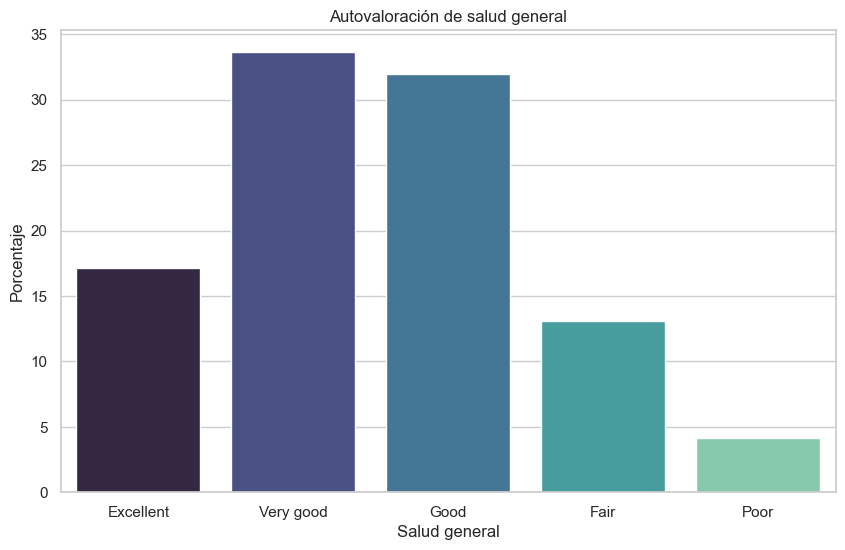

In [9]:
# Crear una lista con las categorías en el orden deseado
categories = ["Excellent", "Very good", "Good", "Fair", "Poor"]

# Convertir la columna GENHLTH en una columna de categorías con el orden especificado
hlthgen = (df.filter(~df["GENHLTH"].isin(["7.0", "9.0"]))
           .groupBy("GENHLTH").count()
           .toPandas()
           .replace({
               "1.0": "Excellent", 
               "2.0": "Very good", 
               "3.0": "Good", 
               "4.0": "Fair",
               "5.0": "Poor"
           })
           .assign(percentage=lambda x: (x["count"] / x["count"].sum()) * 100)
           .assign(GENHLTH=lambda x: pd.Categorical(x["GENHLTH"], categories=categories, ordered=True)))

plt.figure(figsize=(10, 6))
sns.barplot(x="GENHLTH", y="percentage", data=hlthgen, palette="mako")

plt.xlabel("Salud general")
plt.ylabel("Porcentaje")
plt.title("Autovaloración de salud general")

# Muestra el gráfico
plt.show()

<div style="font-family: 'Garamond'; font-size: 14px;">
Y sobre la salud general la mayoría de los encuestados considera tener una salud buena o muy buena